In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.1 MB/s eta 0:00:00


In [ ]:
#melakukan import library
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from jiwer import wer
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:

# Ganti path sesuai lokasi file Anda
csv_path = "/content/drive/MyDrive/databaru/50transkrip.csv"
audio_path = "/content/drive/MyDrive/databaru/dataAudio16Hz"

data = pd.read_csv(csv_path)
data.head()


,filename,bugis,indo
0,1_copy_1.wav,makenni maneng mopa manu'ku,semua ayam saya masih kecil
1,1_copy_2.wav,makenni maneng mopa manu'ku,semua ayam saya masih kecil
2,1_copy_3.wav,makenni maneng mopa manu'ku,semua ayam saya masih kecil
3,1_copy_4.wav,makenni maneng mopa manu'ku,semua ayam saya masih kecil
4,1_copy_5.wav,makenni maneng mopa manu'ku,semua ayam saya masih kecil


In [ ]:
def extract_mfcc_and_melspectrogram(file_path, max_length=143, n_mfcc=15, n_mels=85): # Adjusted max_length and n_mels to potentially match expected shape 143, 100 (15+85)
    # Memuat file audio dengan librosa
    audio, sr = librosa.load(file_path, sr=None)

    # Menghitung MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Menghitung Mel-Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

    # Menyesuaikan panjang MFCC dan Mel-Spectrogram agar sesuai dengan max_length
    # Transpose features to have shape (max_length, n_features) before padding/truncating
    mfcc = mfcc.T
    mel_spectrogram = mel_spectrogram.T

    if mfcc.shape[0] < max_length:
        pad_width = max_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    elif mfcc.shape[0] > max_length:
        mfcc = mfcc[:max_length, :]

    if mel_spectrogram.shape[0] < max_length:
        pad_width = max_length - mel_spectrogram.shape[0]
        mel_spectrogram = np.pad(mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
    elif mel_spectrogram.shape[0] > max_length:
        mel_spectrogram = mel_spectrogram[:max_length, :]

    return mfcc, mel_spectrogram

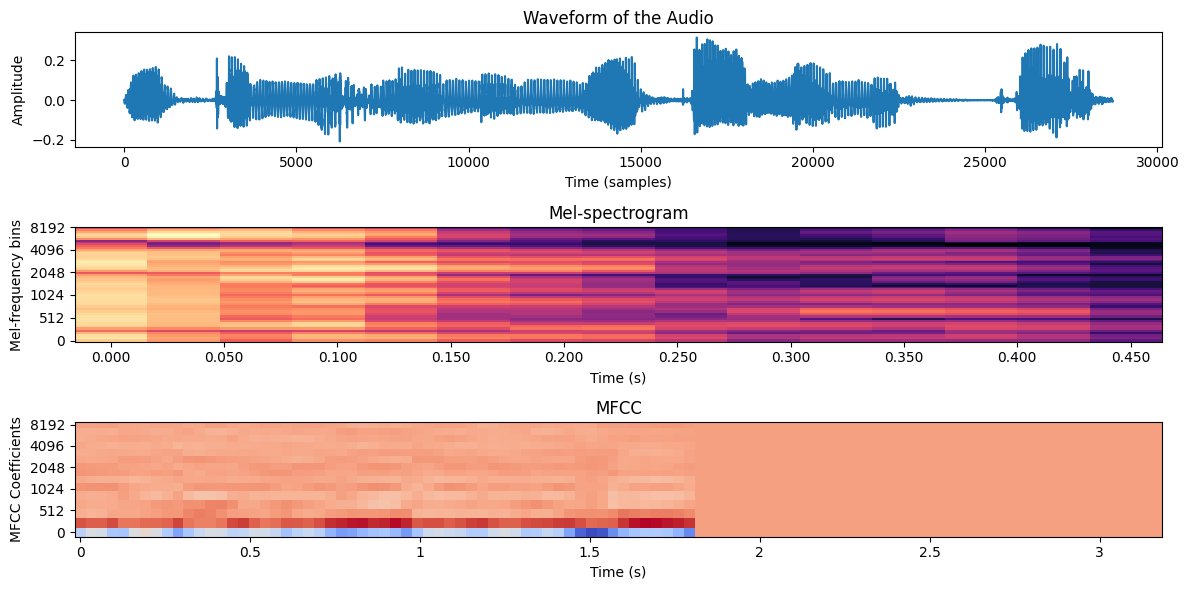

In [ ]:
# Fungsi untuk ekstraksi MFCC dan plot hasilnya
def extract_mfcc_and_plot(file_path, max_length=100, n_mfcc=15):
    # Load audio dengan librosa
    audio, sr = librosa.load(file_path, sr=None)  # sr=None agar sample rate sesuai dengan file

    # Plot Audio Waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(audio)
    plt.title('Waveform of the Audio')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    # Menghitung MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Transpose agar memiliki dimensi (time_steps, n_mfcc)

    # Padding atau pemotongan jika panjang time_steps tidak sesuai dengan max_length
    if mfcc.shape[0] < max_length:
        pad_width = max_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    elif mfcc.shape[0] > max_length:
        mfcc = mfcc[:max_length, :]  # Potong agar panjangnya sesuai max_length

    # Plot Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, n_mels=n_mfcc, fmax=sr/2)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Konversi ke dB
    mel_spec_db = mel_spec_db.T  # Transpose agar memiliki dimensi (time_steps, n_mels)

    plt.subplot(3, 1, 2)
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.title('Mel-spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel-frequency bins')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    librosa.display.specshow(mfcc.T, x_axis='time', y_axis='mel', sr=sr)
    plt.title('MFCC')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

# Gantilah path ini dengan file audio yang sesuai
audio_file_path = '/content/drive/MyDrive/databaru/dataAudio16Hz/1_copy_1.wav'  # Ganti dengan path file audio yang sesuai
extract_mfcc_and_plot(audio_file_path)


In [ ]:
# Inisialisasi X dan y
X = []
y = []

# Loop untuk mengekstrak fitur dari setiap file audio
for i, row in data.iterrows():
    # Construct the full file path, explicitly including the subdirectory
    filepath = os.path.join("/content/drive/MyDrive/databaru/dataAudio16Hz", row["filename"])

    # Ekstraksi MFCC dan Mel-Spectrogram with explicit parameters
    # Features returned by the function are now (max_length, n_features)
    mfcc, mel_spectrogram = extract_mfcc_and_melspectrogram(filepath, n_mfcc=15, n_mels=85) # Explicitly set n_mfcc and n_mels

    # Gabungkan MFCC dan Mel-Spectrogram menjadi satu array fitur
    # Concatenate along the feature dimension (axis=1)
    features = np.concatenate((mfcc, mel_spectrogram), axis=1)

    # Menambahkan fitur dan label ke dalam list
    X.append(features)
    y.append(row["bugis"])

# Mengubah X menjadi array numpy
X = np.array(X)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(y)
y_seq = tokenizer.texts_to_sequences(y)
# Pad sequences and cast to int32
y_padded = pad_sequences(y_seq, padding='post').astype(np.int32)

output_dim = len(tokenizer.word_index) + 1

In [ ]:
# Langkah 1: Pisahkan 10% data untuk test set
# Ensure data types are consistent, casting to int32 for targets
X_temp, X_test, y_temp, y_test = train_test_split(X, y_padded.astype(np.int32), test_size=0.1, random_state=42)

# Langkah 2: Dari sisa 90%, pisahkan 1/9 (~10%) untuk validasi
# Ensure data types are consistent, casting to int32 for targets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp.astype(np.int32), test_size=1/9, random_state=42)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

desired_time_steps = X_train.shape[1]
feature_dimension = X_train.shape[2]
vocab_size = output_dim

model_2 = Sequential([
    # layers.Masking(mask_value=0., input_shape=(desired_time_steps, feature_dimension)),  # Masking sesuai input
    layers.LSTM(128, return_sequences=True, input_shape=(desired_time_steps, feature_dimension)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 143, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 143, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 158)            │        20,382 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,798 (1.53 MB)

 Trainable params: 400,798 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Buat instance EarlyStopping callback


In [ ]:
y_train_single = np.array([seq[0] if len(seq) > 0 else 0 for seq in y_train]).reshape(-1, 1) # Reshape to (None, 1)
y_test_single = np.array([seq[0] if len(seq) > 0 else 0 for seq in y_test]).reshape(-1, 1) # Reshape to (None, 1)

history = model_2.fit(X_train, y_train_single,
                      callbacks=[EarlyStopping(
    monitor='val_accuracy',  # Metrik yang dipantau
    patience=5,              # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True # Mengembalikan bobot model dari epoch terbaik
)], # Added comma here
                      epochs=500, batch_size=32, validation_data=(X_test, y_test_single))

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.0331 - loss: 4.5647 - val_accuracy: 0.0240 - val_loss: 3.8858
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0663 - loss: 3.8047 - val_accuracy: 0.0240 - val_loss: 3.8272
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0685 - loss: 3.7991 - val_accuracy: 0.0280 - val_loss: 3.8214
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0654 - loss: 3.7943 - val_accuracy: 0.0240 - val_loss: 3.8632
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0570 - loss: 3.7917 - val_accuracy: 0.0240 - val_loss: 3.8326
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0662 - loss: 3.7802 - val_accuracy: 0.0240 - val_loss: 3.8336
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0603 - loss: 3.7729 - val_accuracy: 0.0240 - val_loss: 3.8100
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0597 - loss: 3.7951 - val_accuracy: 0.

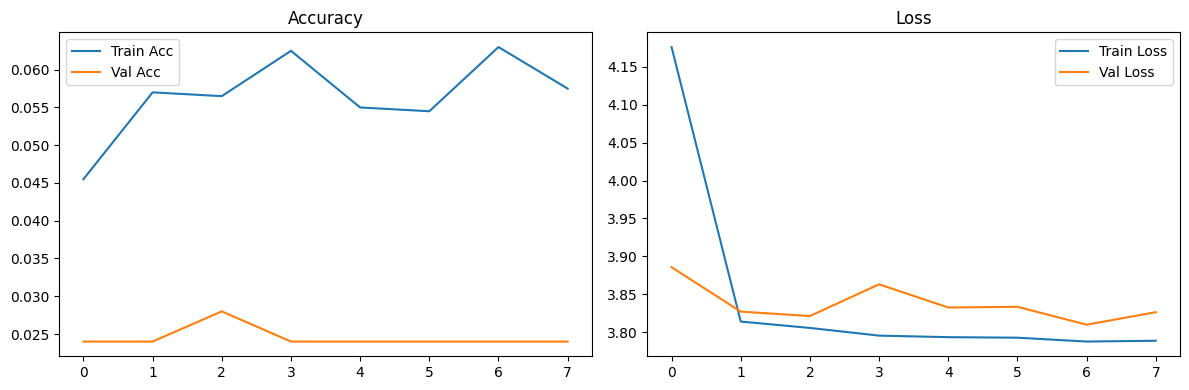

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


✅ 1. Pengujian Langsung (STT dari File Audio)

In [ ]:
def predict_stt_from_audio(model, audio_feature, tokenizer):
    # Memastikan audio_feature sudah berupa array fitur (MFCC dan Mel-Spectrogram)
    # audio_feature is expected to be a single numpy array with shape (max_length, n_features)
    features = audio_feature

    # Menambahkan dimensi batch agar sesuai dengan input model
    features = np.expand_dims(features, axis=0)

    # Melakukan prediksi dengan model
    predicted_numbers = model.predict(features)

    # Ambil indeks kelas dengan probabilitas tertinggi
    pred_indices = np.argmax(predicted_numbers, axis=-1)[0] # Take the first sample in the batch

    # Jika pred_indices hanya berupa satu angka (satu prediksi), ubah menjadi list
    if isinstance(pred_indices, np.int64):
        pred_indices = [pred_indices]  # Ubah menjadi list agar bisa diiterasi


    # Mendekode hasil prediksi menjadi teks
    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    # Decode each predicted index to a word, excluding padding (usually index 0)
    result = ' '.join([index_to_word.get(int(idx), '') for idx in pred_indices if idx != 0])

    return result.strip()

In [ ]:
# Fungsi untuk melihat hasil dari 10 audio acak
def predict_multiple_audio_to_text(model, audio_files, actual_texts, tokenizer, num_samples=30):
    # Pilih 10 audio acak dari data validasi
    random_indices = random.sample(range(len(audio_files)), num_samples)

    predicted_texts = []
    actual_texts_subset = []

    # Proses prediksi untuk 10 file audio acak
    for idx in random_indices:
        audio_file = audio_files[idx]
        actual_text = actual_texts[idx]

        # Ekstraksi fitur MFCC dan Mel-Spectrogram dari file audio
        # Use the updated extract_mfcc_and_melspectrogram which returns (max_length, n_features)
        mfcc, mel_spectrogram = extract_mfcc_and_melspectrogram(audio_file)

        # Gabungkan MFCC dan Mel-Spectrogram (sudah dalam bentuk yang benar (max_length, n_features))
        features = np.concatenate((mfcc, mel_spectrogram), axis=1)

        # Prediksi untuk satu file audio menggunakan predict_stt_from_audio
        # Pass the combined features array
        predicted_text = predict_stt_from_audio(model, features, tokenizer)

        # Menyimpan hasil prediksi dan teks aktual
        predicted_texts.append(predicted_text)
        actual_texts_subset.append(actual_text)

    # Menampilkan hasil prediksi dan teks aktual dengan format yang lebih terstruktur
    for i in range(num_samples):
        print(f"Audio {i + 1}:")
        print(f"Predicted text: {predicted_texts[i]}")
        print(f"Actual text: {actual_texts_subset[i]}")
        print("-" * 50)

# Memuat data dari CSV (pastikan ini sudah dijalankan sebelumnya)
# csv_path = "/content/drive/MyDrive/databaru/50transkrip.csv"
# data = pd.read_csv(csv_path) # Assuming 'data' is already loaded

# Menyimpan path file audio dan teks dari kolom 'bugis'
# Explicitly define audio_path here to ensure correctness
audio_path = "/content/drive/MyDrive/databaru/dataAudio16Hz"
audio_files = [os.path.join(audio_path, filename) for filename in data['filename']]  # Pastikan kolom 'filename' ada di CSV
actual_texts = data['bugis'].tolist()  # Mengambil teks dari kolom 'bugis'

# Tokenizer (gunakan tokenizer yang sesuai dengan model yang digunakan)
# from tensorflow.keras.preprocessing.text import Tokenizer # Assuming Tokenizer is already imported and fitted
# tokenizer = Tokenizer() # Assuming tokenizer is already initialized and fitted
# tokenizer.fit_on_texts(actual_texts) # Assuming tokenizer is already fitted

# Panggil fungsi untuk melihat hasil prediksi dan teks aktual untuk 10 data acak
# Make sure 'model' is the trained model (e.g., model_2)
predict_multiple_audio_to_text(model_2, audio_files, actual_texts, tokenizer, num_samples=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [ ]:
import numpy as np
import librosa
import pandas as pd
import os
import jiwer

# Load the data
csv_path = "/content/drive/MyDrive/databaru/50transkrip.csv"
data = pd.read_csv(csv_path)

# Fungsi untuk memprediksi teks dari audio menggunakan model
def predict_stt_from_audio(model, audio_file, tokenizer):
    # Ekstraksi fitur MFCC dan Mel-Spectrogram dari file audio
    mfcc, mel_spectrogram = extract_mfcc_and_melspectrogram(audio_file)

    # Menambahkan dimensi batch agar sesuai dengan input model
    mfcc = np.expand_dims(mfcc, axis=0)
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)

    # Menggabungkan MFCC dan Mel-Spectrogram
    # Concatenate along the feature dimension (axis=2) after adding batch dimension
    features = np.concatenate((mfcc, mel_spectrogram), axis=2)

    # Prediksi dengan model
    pred = model.predict(features)

    # Mengambil token dengan probabilitas tertinggi
    pred_indices = np.argmax(pred, axis=-1)[0]

    # Jika pred_indices hanya berupa satu angka (satu prediksi), ubah menjadi list
    if isinstance(pred_indices, np.int64):
        pred_indices = [pred_indices]  # Ubah menjadi list agar bisa diiterasi

    # Mendekode hasil prediksi menjadi teks
    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    result = ' '.join([index_to_word.get(int(idx), '') for idx in pred_indices if idx != 0])

    return result.strip()

# Misalnya, daftar kalimat asli dan terjemahan dari model
true_transcripts = data["bugis"].tolist()  # Teks yang benar (Bugis)

# Membuat tokenizer dan melatihnya dengan data teks yang benar
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(true_transcripts)  # Melatih tokenizer dengan teks yang benar

# Membuat daftar file audio dengan path lengkap
audio_path = "/content/drive/MyDrive/databaru"  # Ganti dengan path yang sesuai
audio_files = [os.path.join(audio_path, "dataAudio16Hz", fname) for fname in data["filename"]]  # Path lengkap ke file audio

# Prediksi untuk setiap file audio
# Make sure 'model_2' (the trained model) is used here, not 'model'
predicted_transcripts = [predict_stt_from_audio(model_2, audio_file, tokenizer)
                         for audio_file in audio_files]

# Evaluasi WER
wer_score = jiwer.wer(true_transcripts, predicted_transcripts)
print(f"Word Error Rate (WER): {wer_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [ ]:
# Download the necessary data for NLTK if you haven't already
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


# Function to calculate BLEU score for a list of sentences
def calculate_bleu_score(reference_sentences, hypothesis_sentences):
    bleu_scores = []
    # Define a smoothing function
    chencherry = SmoothingFunction()
    for reference, hypothesis in zip(reference_sentences, hypothesis_sentences):
        # BLEU score requires tokenized sentences
        reference_tokens = [nltk.word_tokenize(reference.lower())] # Reference needs to be a list of token lists
        hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

        # Calculate BLEU score for each sentence pair with smoothing
        # Using weights for BLEU-4, you can adjust weights for other BLEU variants
        score = sentence_bleu(reference_tokens, hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
        bleu_scores.append(score)
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

# Calculate the overall BLEU score
overall_bleu_score = calculate_bleu_score(true_transcripts, predicted_transcripts)
print(f"Overall BLEU Score: {overall_bleu_score}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Overall BLEU Score: 0.00022983262749618483


In [ ]:
# Assuming true_transcripts and predicted_transcripts are already defined
# and are lists of strings of the same length.
# --- BLEU Evaluation Table ---
bleu_data = []
chencherry = SmoothingFunction() # Define smoothing function once
for i, (reference, hypothesis) in enumerate(zip(true_transcripts, predicted_transcripts)):
    # BLEU score requires tokenized sentences
    reference_tokens = [nltk.word_tokenize(reference.lower())] # Reference needs to be a list of token lists
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    # Calculate BLEU score for each sentence pair with smoothing
    score = sentence_bleu(reference_tokens, hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
    bleu_data.append([i + 1, reference, hypothesis, score * 100]) # Multiply by 100 for percentage

bleu_df = pd.DataFrame(bleu_data, columns=['No', 'Teks Aktual', 'Hasil Transkripsi', 'Skor BLEU (%)'])
print("\n--- BLEU Evaluation Table ---")
display(bleu_df)


--- BLEU Evaluation Table ---


,No,Teks Aktual,Hasil Transkripsi,Skor BLEU (%)
0,1,makenni maneng mopa manu'ku,e,0.00000
1,2,makenni maneng mopa manu'ku,e,0.00000
2,3,makenni maneng mopa manu'ku,e,0.00000
3,4,makenni maneng mopa manu'ku,e,0.00000
4,5,makenni maneng mopa manu'ku,e,0.00000
...,...,...,...,...
2495,2496,mitauka jokka dare'e cilaleku,e,0.11982
2496,2497,mitauka jokka dare'e cilaleku,e,0.11982
2497,2498,mitauka jokka dare'e cilaleku,e,0.11982
2498,2499,mitauka jokka dare'e cilaleku,bawang,0.00000


In [ ]:
# Re-calculate WER data with S, D, I, and N
wer_data = []
for actual, predicted in zip(true_transcripts, predicted_transcripts):
    # Calculate WER and measures for each sentence pair using process_words
    comparison = jiwer.process_words(actual, predicted)
    s_count = comparison.substitutions
    d_count = comparison.deletions
    i_count = comparison.insertions
    n_count = comparison.hits + comparison.substitutions + comparison.deletions # N = H + S + D
    wer_score = comparison.wer * 100 # WER is already calculated by process_words

    wer_data.append([actual, predicted, s_count, d_count, i_count, n_count, wer_score])

# Update the WER DataFrame with the correct columns
wer_df = pd.DataFrame(wer_data, columns=['Teks Aktual', 'Hasil Transkripsi', 'S', 'D', 'I', 'N', 'WER (%)'])

print("--- Updated WER Evaluation Table ---")
display(wer_df)

--- Updated WER Evaluation Table ---


,Teks Aktual,Hasil Transkripsi,S,D,I,N,WER (%)
0,makenni maneng mopa manu'ku,e,1,3,0,4,100.0
1,makenni maneng mopa manu'ku,e,1,3,0,4,100.0
2,makenni maneng mopa manu'ku,e,1,3,0,4,100.0
3,makenni maneng mopa manu'ku,e,1,3,0,4,100.0
4,makenni maneng mopa manu'ku,e,1,3,0,4,100.0
...,...,...,...,...,...,...,...
2495,mitauka jokka dare'e cilaleku,e,1,3,0,4,100.0
2496,mitauka jokka dare'e cilaleku,e,1,3,0,4,100.0
2497,mitauka jokka dare'e cilaleku,e,1,3,0,4,100.0
2498,mitauka jokka dare'e cilaleku,bawang,1,3,0,4,100.0


In [ ]:
# Save the updated DataFrames to an Excel file
excel_output_dir = "/content/drive/My Drive/Tugas akhir/kodeProgram"
excel_output_path = os.path.join(excel_output_dir, "evaluation_results_model1.xlsx")

# Create the directory if it doesn't exist
os.makedirs(excel_output_dir, exist_ok=True)

with pd.ExcelWriter(excel_output_path) as writer:
    wer_df.to_excel(writer, sheet_name='WER_Evaluation', index=False)
    bleu_df.to_excel(writer, sheet_name='BLEU_Evaluation', index=False) # Keep the BLEU table as is

print(f"Updated evaluation tables saved to {excel_output_path}")

Updated evaluation tables saved to /content/drive/My Drive/Tugas akhir/kodeProgram/evaluation_results_model1.xlsx
